In [1]:
import scanpy as sc

import pandas as pd
import numpy as np

import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import scipy
from scipy.stats import spearmanr
from scipy.stats import zscore
from scipy.stats import pearsonr
from sklearn.metrics import pairwise_distances

# utils function -- helper functions for plotting
import sys
sys.path.append('../../utils/')
import figure_utils as figure_utils

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 500 # 150 dpi resolution
matplotlib.rcParams['image.cmap'] = 'Spectral_r' # preferred color map
# matplotlib.rcParams['figure.figsize'] = [6, 6] # Square
# no bounding boxes or axis:
matplotlib.rcParams['axes.spines.bottom'] = "off"
matplotlib.rcParams['axes.spines.top'] = "off"
matplotlib.rcParams['axes.spines.left'] = "off"
matplotlib.rcParams['axes.spines.right'] = "off"

In [3]:
# UMAP PARAMS
DOT_SIZE = 25
LEGEND_FONTSIZE = 8
LEGEND_FONTOUTLINE = 1
UMAP_FIGSIZE = (10,10)

# SEXES COLOR -- OLD
# HERM_COLOR = '#f58020'
# MALE_COLOR = '#1479b8'
# SHARED_SEX_COLOR = '#c2b69b'

# SEXES COLOR -- NEW
HERM_COLOR = '#ff8b00'
MALE_COLOR = '#2258a5'
SHARED_SEX_COLOR = '#349c55'

# HEATMAP COLOR AESTHETICS
PLOTLY_COLOR_TEMPLATE = 'plotly_white'
HEATMAP_COLOR = [[0,'rgb(250,250,250)'], [1,'rgb(102,0,204)']]
HEATMAP_MIN_COLOR = 0
HEATMAP_MAX_COLOR = 4

In [4]:
# load data
adata = sc.read('../../data/WholeData.h5ad')
adata_glia = sc.read('../../data/GliaOnly.h5ad')

# Figure 6A -- Transcription Factor Differential Expression Analysis

In [5]:
adata_DE = adata_glia[:,adata_glia.var['transcription_factors']].copy()
adata_DE = adata_DE[adata_DE.obs['sex_specificity'] == 'Both',:]
adata_DE

View of AnnData object with n_obs × n_vars = 15893 × 640
    obs: 'Celltype', 'sex_specificity', 'leiden_postBC', 'sex', 'SheathSocket_label', 'Compartments', 'leiden_preBC', 'cluster_sex_label', 'Cluster_Celltype'
    var: 'highly_variable', 'previous_highly_variable', 'transcription_factors', 'transporters', 'neuropeptides'
    uns: 'BatchCorrected_LeidenClusters_colors', 'Compartments_colors', 'FiguresData_Sheath_Selection_Results', 'FiguresData_Socket_Selection_Results', 'Identified_SheathSocket_Markers', 'SheathSocket_label_colors', 'Validations_colors', 'cluster_sex_label_colors', 'dendrogram_Cluster_Celltype', 'gene_validations', 'leiden_noBC_colors', 'leiden_postBC_colors', 'sex_colors', 'sex_frac_Glia_postBC', 'sex_specificity_colors'
    obsm: 'DM_EigenVectors_postBC', 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_noBC'
    varm: 'cluster_means', 'pairwise_cluster_count'
    layers: 'magic_imputed_postBC'

In [6]:
# perform differential expression analysis -- Herm vs Male
sc.tl.rank_genes_groups(adata_DE, groupby='sex', key_added='shared_sex_tf_DE', use_raw=False)

/home/equitevi/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [7]:
# process differential expression analysis results
de_tf_global = sc.get.rank_genes_groups_df(adata_DE, group=None, key='shared_sex_tf_DE')
de_tf_global.loc[:,'log_pvals_adj'] = -1 * np.log10(de_tf_global.loc[:,'pvals_adj'])

# helper function for identifying upregulated/downregulated genes
pvals_adj = 1e-3
logFC_upreg = 1.5
logFC_downreg = -1.5

def upreg_downreg(input_val):
    fc_value, pval = input_val
    if fc_value > logFC_upreg and pval <= pvals_adj:
        return 'upregulated'
    elif fc_value < logFC_downreg and pval <= pvals_adj:
        return 'downregulated'
    else:
        return 'unchanged'

# gene labels -- upregulated and downregulated
de_tf_global.loc[:,'gene_labels'] = de_tf_global.loc[:,['logfoldchanges','pvals_adj']].apply(upreg_downreg, axis=1)

# color labels for 
dict_color = {'upregulated':HERM_COLOR,'downregulated':MALE_COLOR,'unchanged':'darkgray'}
de_tf_global.loc[:,'color_gene_label'] = de_tf_global.loc[:,'gene_labels'].map(dict_color)

# check
de_tf_global.head()

group  names     scores  logfoldchanges          pvals  \
0  Hermaphrodite  mdl-1  35.659050        1.618372  6.733742e-268   
1  Hermaphrodite  cey-4  25.739534        1.509316  4.263071e-143   
2  Hermaphrodite  mxl-3  22.334381        1.637368  9.540181e-109   
3  Hermaphrodite  atf-8  19.590212        2.083834   2.110442e-84   
4  Hermaphrodite  ech-6  18.604874        1.733482   2.162516e-76   

       pvals_adj  log_pvals_adj  gene_labels color_gene_label  
0  4.309595e-265     264.365564  upregulated          #ff8b00  
1  1.364183e-140     139.865127  upregulated          #ff8b00  
2  1.526429e-106     105.816323  upregulated          #ff8b00  
3   2.251138e-82      81.647598  upregulated          #ff8b00  
4   1.977157e-74      73.703959  upregulated          #ff8b00

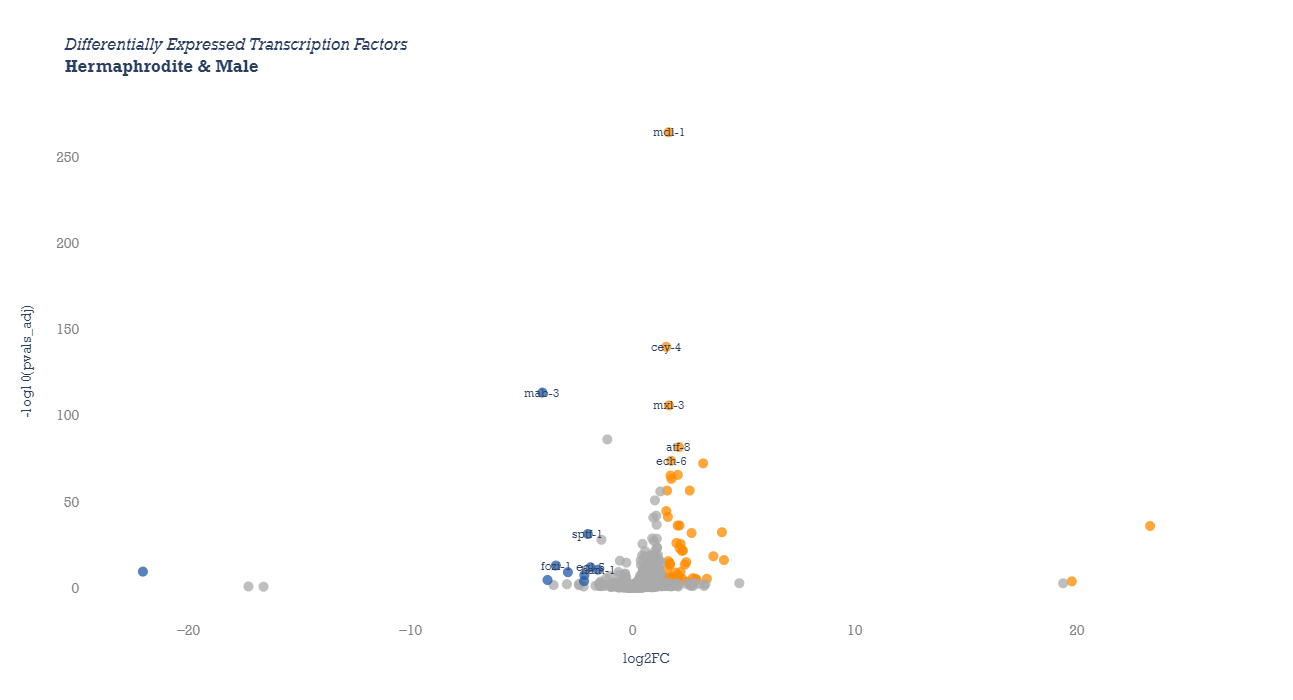

In [8]:
# plot the genes
de_scatter_volcano = go.Figure()
de_scatter_volcano.add_trace(
    go.Scatter(
        x=de_tf_global.loc[de_tf_global['group'] == 'Hermaphrodite','logfoldchanges'],
        y=de_tf_global.loc[de_tf_global['group'] == 'Hermaphrodite','log_pvals_adj'],
        mode='markers',
        hovertext=de_tf_global.loc[de_tf_global['group'] == 'Hermaphrodite','names'],
    )
)

de_scatter_volcano.update_traces(
    marker=dict(
        opacity=0.75,
        color=de_tf_global.loc[de_tf_global['group'] == 'Hermaphrodite','color_gene_label'],
        size=10
    )
)


de_scatter_volcano.update_layout(
#     template='presentation',
    width=700,
    height=700,
    xaxis=dict(title='log2FC', gridcolor='lightgray'),
    yaxis=dict(title='-log10(pvals_adj)', gridcolor='lightgray'),
    plot_bgcolor='rgba(0,0,0,0)',
    title=f'<i>Differentially Expressed Transcription Factors</i>  <br><b>Hermaphrodite & Male</b>',
    font=dict(
        family='Rockwell'
    ),
#     plot_bgcolor='rgba(0,0,0,0)'
)


# highlight the following -- top 5 upregulated for each group
upregulated_herm = de_tf_global.loc[(de_tf_global['group'] == 'Hermaphrodite') & \
                                    (de_tf_global['gene_labels'] == 'upregulated'),['names','logfoldchanges','log_pvals_adj']][:5]
upregulated_male = de_tf_global.loc[(de_tf_global['group'] == 'Male') & \
                                    (de_tf_global['gene_labels'] == 'upregulated'),['names','logfoldchanges','log_pvals_adj']][:5]
upregulated_male.iloc[:,-2] = upregulated_male.iloc[:,-2] * -1

annotations = pd.concat([upregulated_herm, upregulated_male])

for _, (name, logfc, logpvals) in annotations.iterrows():
    de_scatter_volcano.add_annotation(
        x=logfc,
        y=logpvals,
        text=name,
        showarrow=False,
        align='left'
    )

# customize fonts
de_scatter_volcano.update_yaxes(showgrid=False, tickfont=dict(family='Rockwell', color='gray', size=14))
de_scatter_volcano.update_xaxes(showgrid=False, tickfont=dict(family='Rockwell', color='gray', size=14))

# visualize
de_scatter_volcano.write_image("figures/figure_6A_DEA_TF_SharedSexes_VolcanoPlot.png")
de_scatter_volcano.write_html("figures/figure_6A_DEA_TF_SharedSexes_VolcanoPlot.html")
de_scatter_volcano.show()

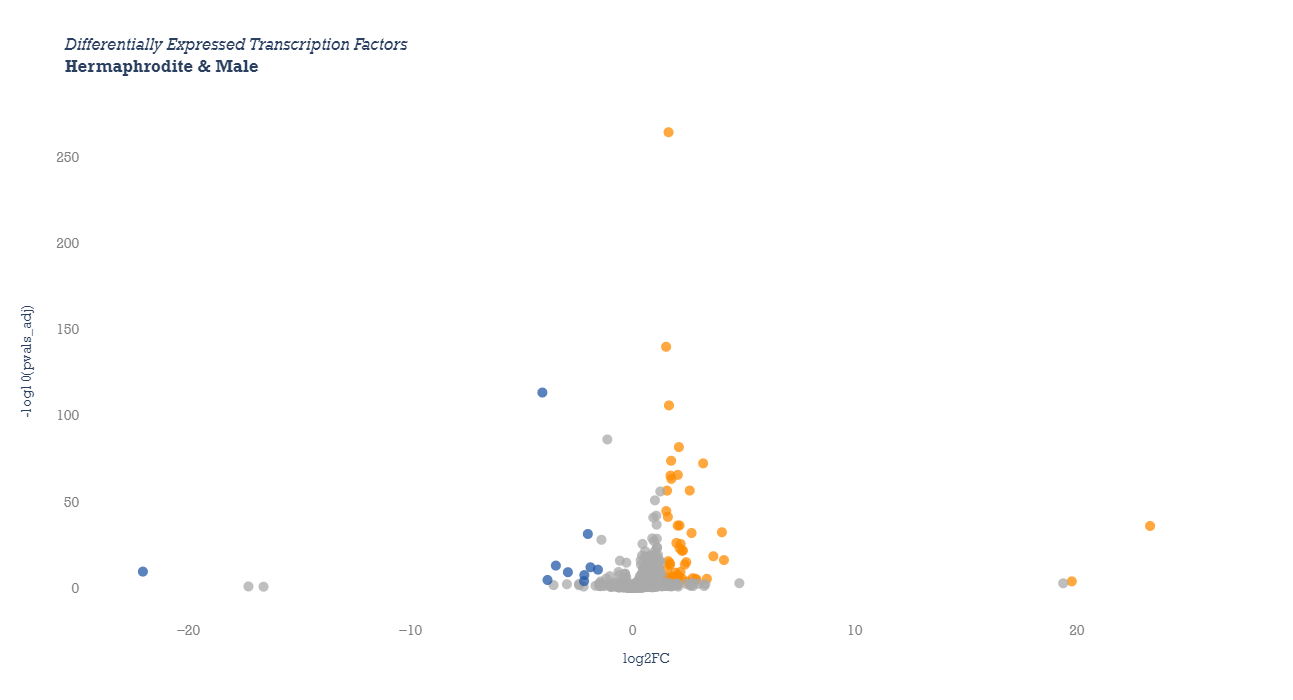

In [9]:
# UNLABELED VERSION
de_scatter_volcano = go.Figure()
de_scatter_volcano.add_trace(
    go.Scatter(
        x=de_tf_global.loc[de_tf_global['group'] == 'Hermaphrodite','logfoldchanges'],
        y=de_tf_global.loc[de_tf_global['group'] == 'Hermaphrodite','log_pvals_adj'],
        mode='markers',
        hovertext=de_tf_global.loc[de_tf_global['group'] == 'Hermaphrodite','names'],
    )
)

de_scatter_volcano.update_traces(
    marker=dict(
        opacity=0.75,
        color=de_tf_global.loc[de_tf_global['group'] == 'Hermaphrodite','color_gene_label'],
        size=10
    )
)

de_scatter_volcano.update_layout(
#     template='presentation',
    width=700,
    height=700,
    xaxis=dict(title='log2FC', gridcolor='lightgray'),
    yaxis=dict(title='-log10(pvals_adj)',gridcolor='lightgray'),
    plot_bgcolor='rgba(0,0,0,0)',
    title=f'<i>Differentially Expressed Transcription Factors</i>  <br><b>Hermaphrodite & Male</b>',
    font=dict(
        family='Rockwell'
    ),
)

# customize fonts
de_scatter_volcano.update_yaxes(showgrid=False, tickfont=dict(family='Rockwell', color='gray', size=14))
de_scatter_volcano.update_xaxes(showgrid=False, tickfont=dict(family='Rockwell', color='gray', size=14))


# visualize
de_scatter_volcano.show()
de_scatter_volcano.write_image("figures/figure_6A_DEA_TF_SharedSexes_VolcanoPlot_Unlabeled.png")
de_scatter_volcano.write_html("figures/figure_6A_DEA_TF_SharedSexes_VolcanoPlot_Unlabeled.html")

# Figure 6B -- Cluster 3 Highlighted

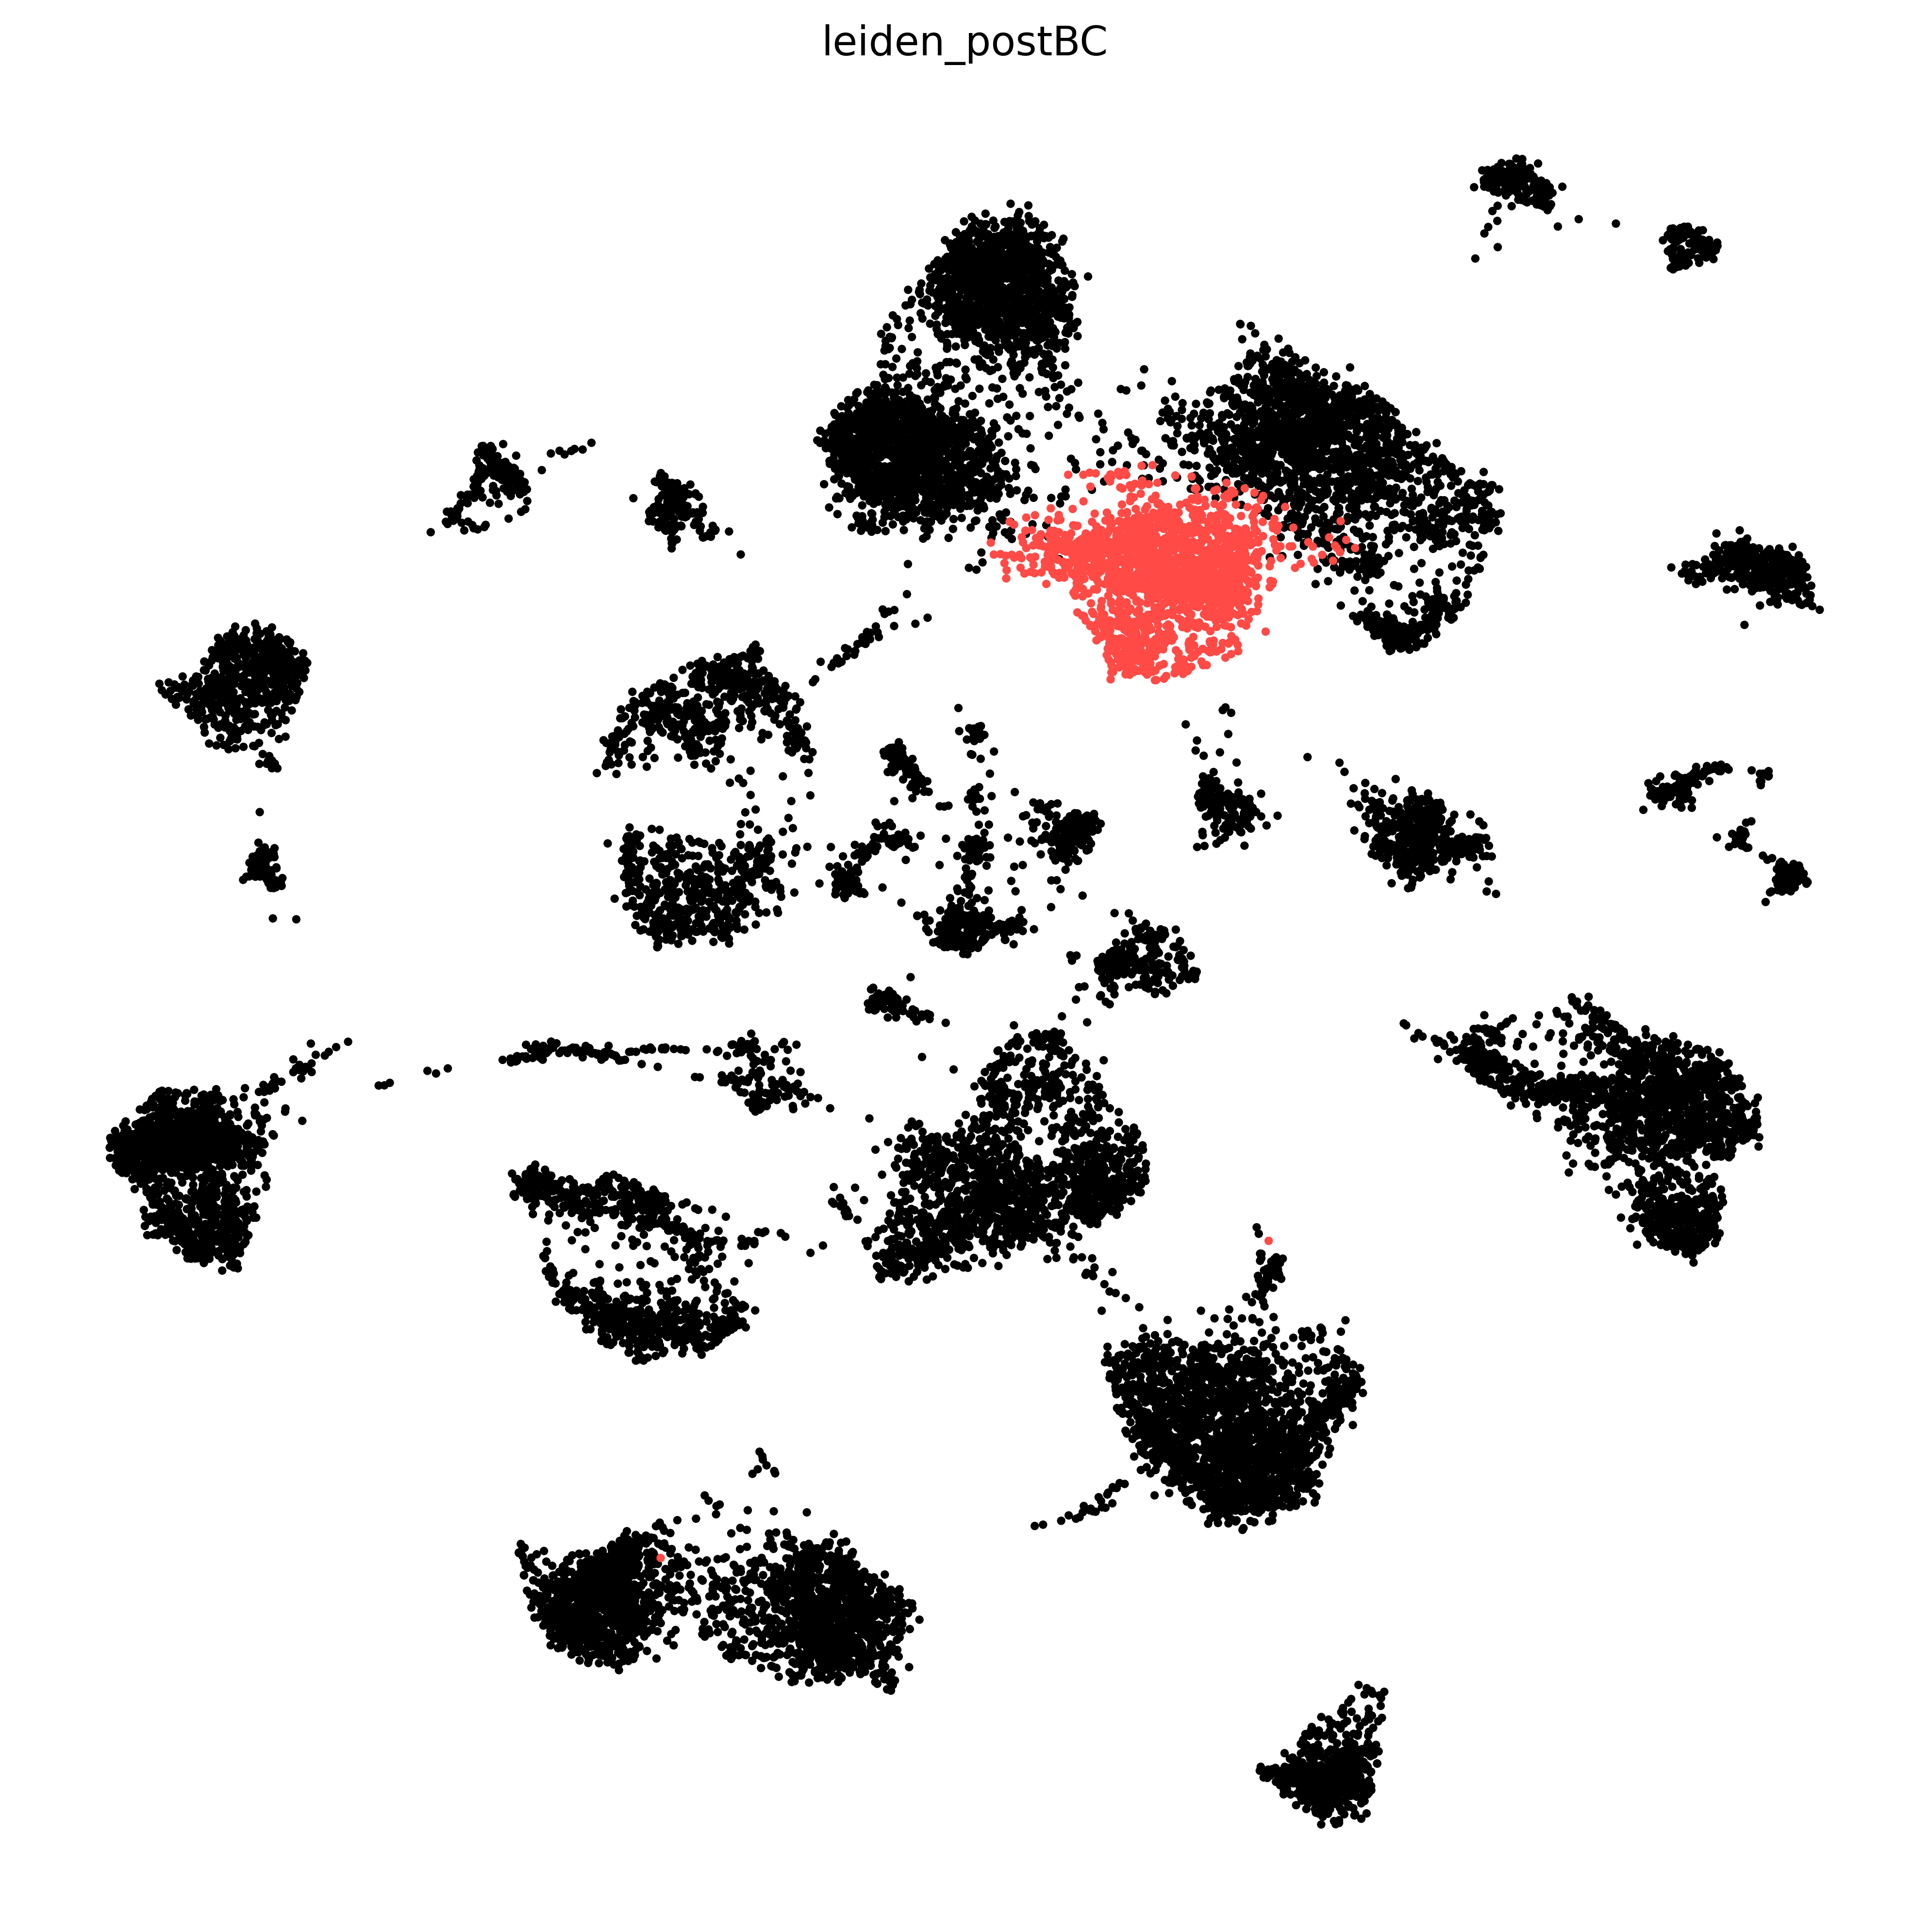

In [10]:
with matplotlib.pyplot.rc_context({'figure.figsize':UMAP_FIGSIZE}):
    sc.pl.umap(
        adata_glia,
        color=['leiden_postBC'],
        groups=['3'],
        frameon=False,
        legend_loc=None,
        size=DOT_SIZE,
        na_color='#000000',
        save='figure_6B_Highlight_Cluster3.png',
    )

# Figure 6C -- Cluster 16 Highlighted

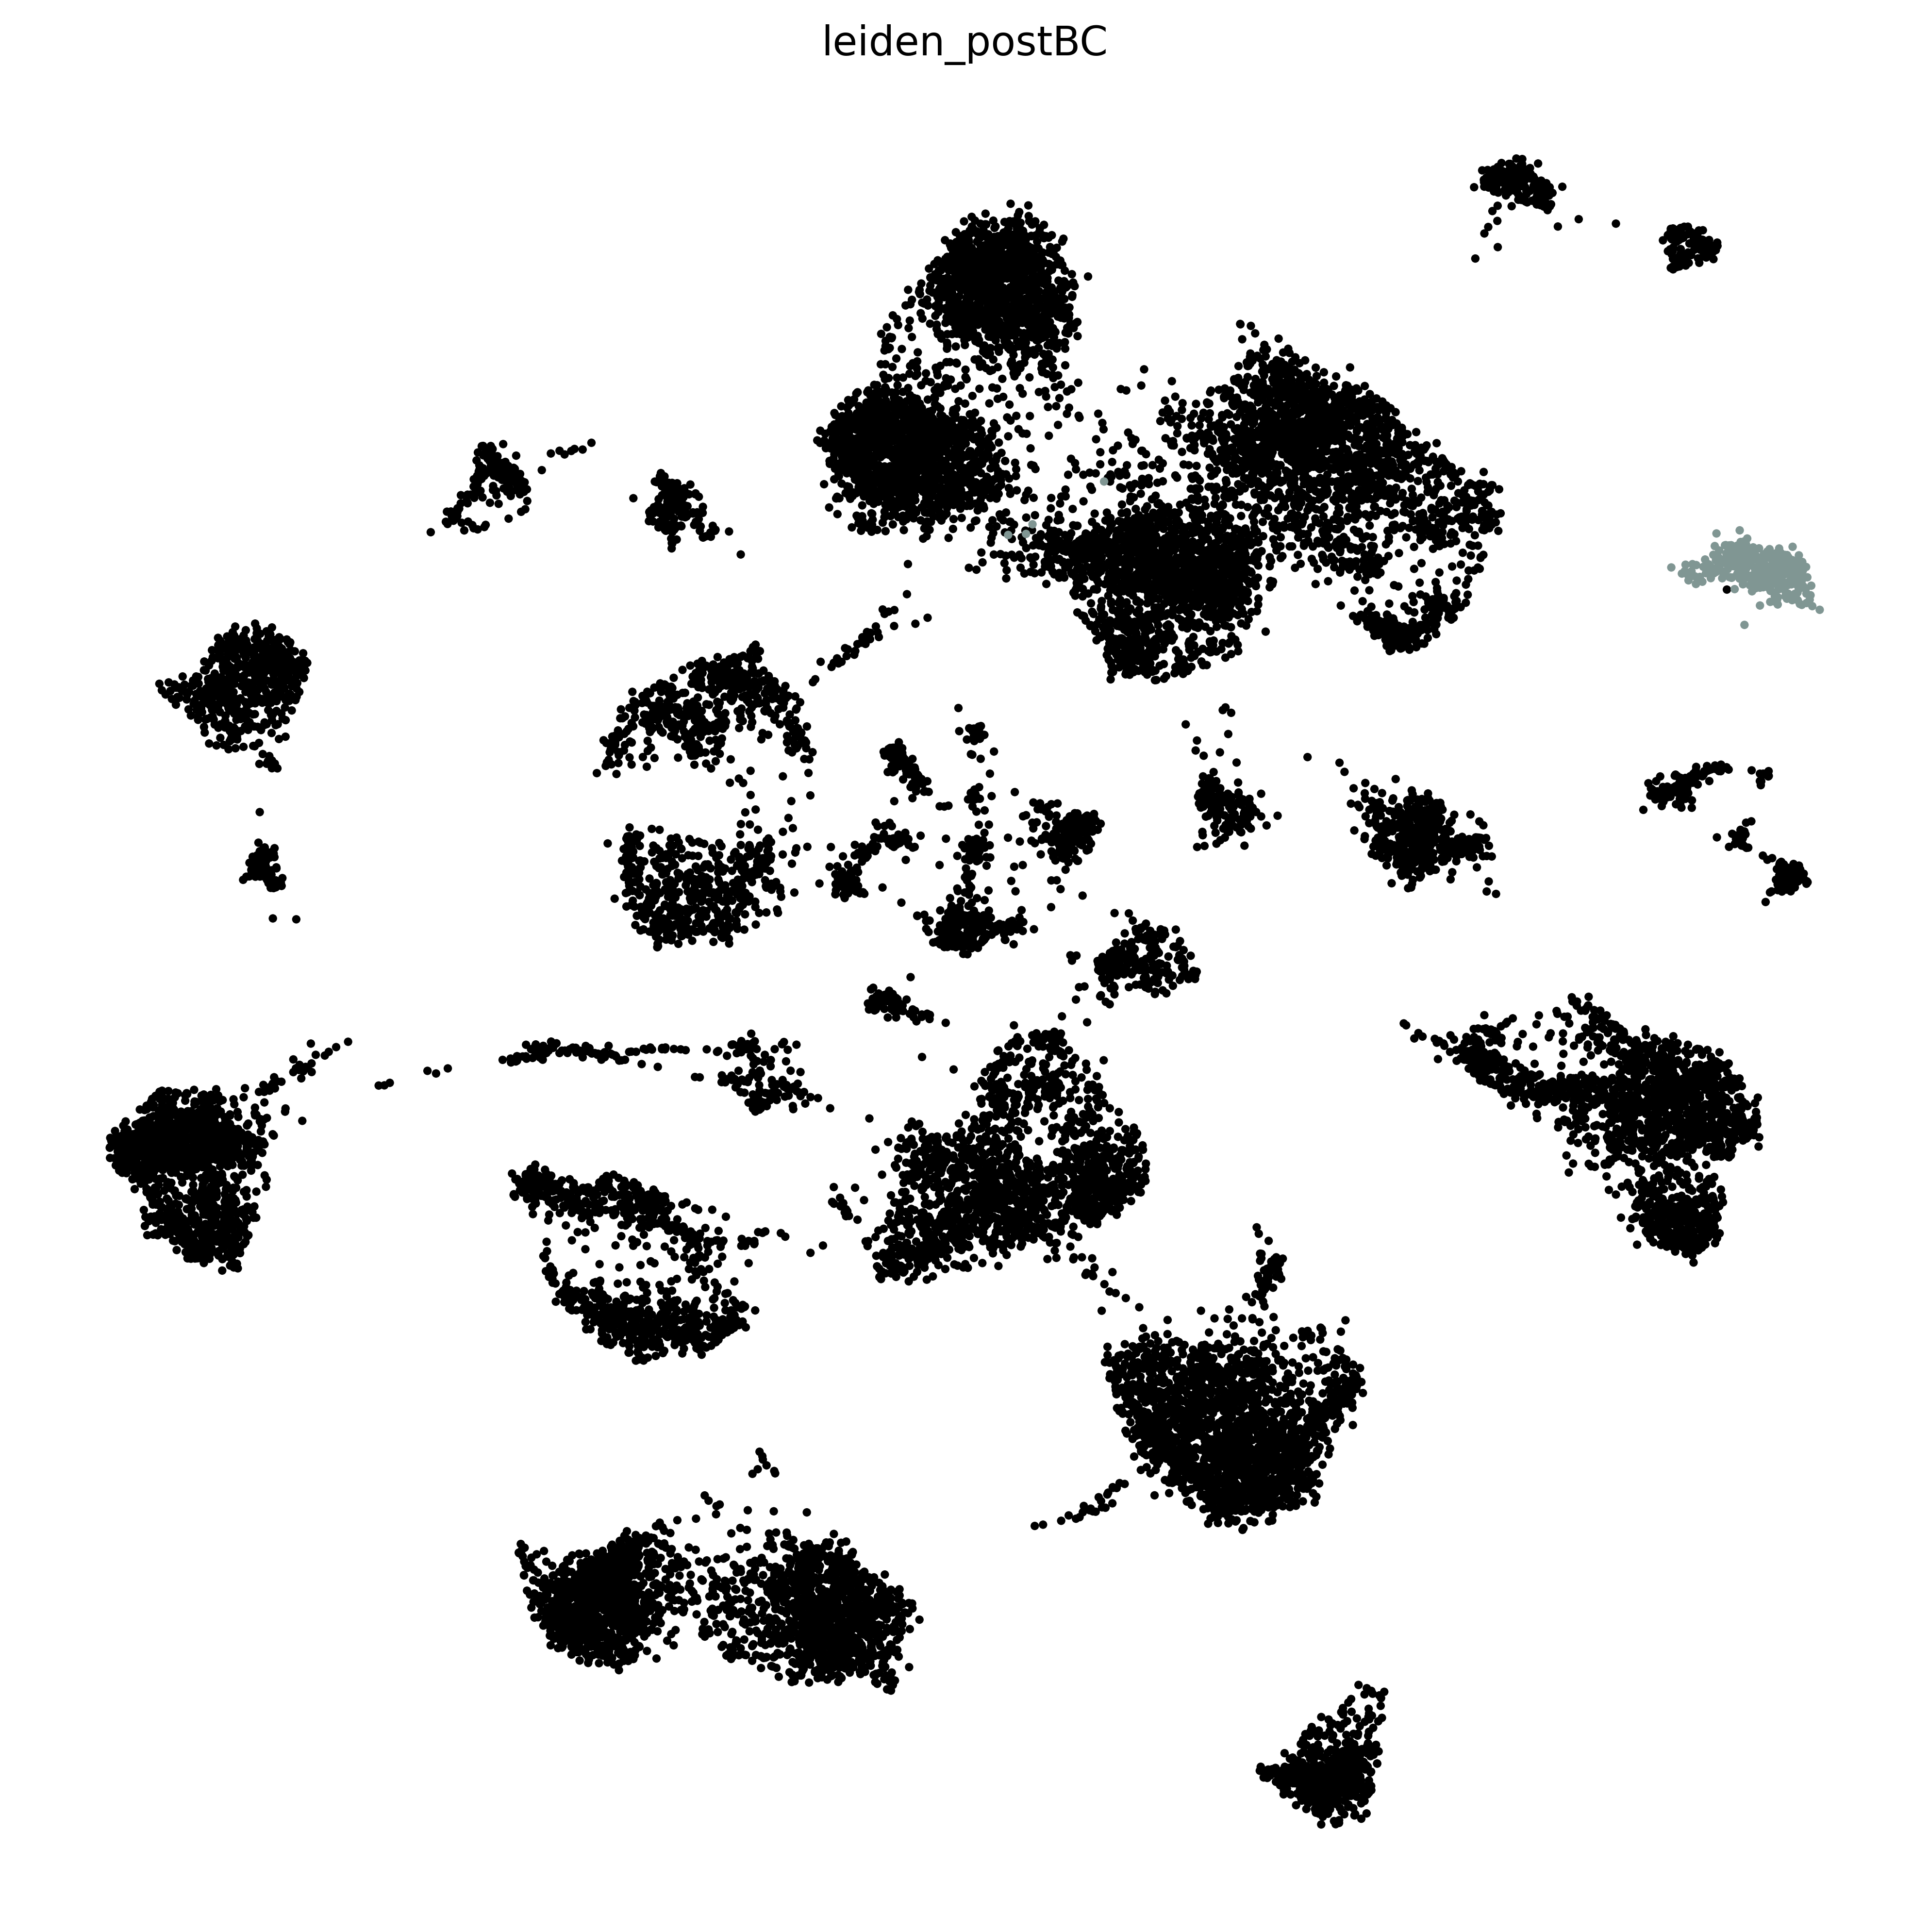

In [11]:
with matplotlib.pyplot.rc_context({'figure.figsize':UMAP_FIGSIZE}):
    sc.pl.umap(
        adata_glia,
        color=['leiden_postBC'],
        groups=['16'],
        frameon=False,
        legend_loc=None,
        size=DOT_SIZE,
        na_color='#000000',
        save='figure_6C_Highlight_Cluster16.png',
    )